In [1]:
import gc

import matplotlib.pyplot as plt
import torch
from fontTools.misc.cython import returns
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

from torch.func import jacrev, jacfwd, vmap
from torch.distributions import MultivariateNormal

from stochman.manifold import EmbeddedManifold
from stochman.geodesic import geodesic_minimizing_energy
from stochman import CubicSpline

from circular_utils import *
from plot_utils import *

In [2]:
# Parameters
num_points = 300
r_inner = 0.7  # Inner radius (hole radius)
r_outer = 1.0  # Outer radius

In [3]:
# Generate points
data = generate_annular_points(num_points, r_inner, r_outer)
#data_3d = generate_annular_points_3d(num_points, r_inner, r_outer)
grid_size = 100
z_grid, x_lin, y_lin = generate_grid(grid_size=grid_size, device='cpu')

In [4]:
#simple_2d_plot(data, num_points)

In [5]:
dm = DensityMetric(data, 0.1)
real_bg = dm.density(z_grid.reshape(-1, 2)).reshape((grid_size, grid_size))

In [6]:
num_curves = 30
N, D = data.shape
curve_indices = torch.randint(data.shape[0], (num_curves, 2))  # (num_curves) x 2

In [7]:
batch_c = CubicSpline(begin=data[curve_indices[:, 0]], end=data[curve_indices[:, 1]], num_nodes=20)
geodesic_minimizing_energy(curve=batch_c, manifold=dm, optimizer=torch.optim.RMSprop, max_iter=250)

tensor(False)

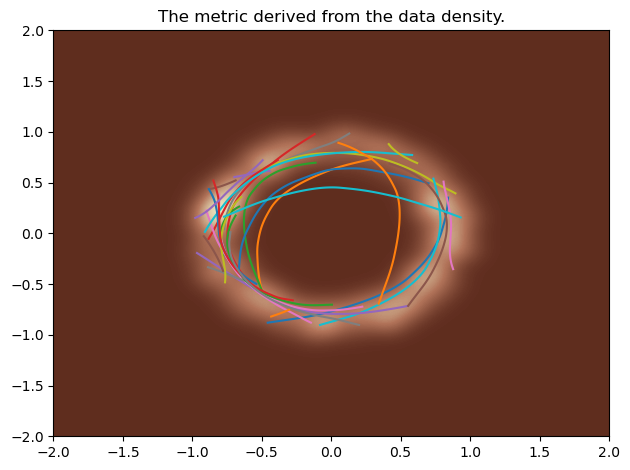

In [8]:
plt.scatter(data[:, 0], data[:, 1], s=1, alpha=0.5)
plt.contourf(x_lin, y_lin, real_bg, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
batch_c.plot()
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.title("The metric derived from the data density.")
plt.tight_layout()
plt.show()

In [9]:
batch_c.euclidean_length().mean().item()

1.2259948253631592

In [15]:
data_vae = embed_points_2d_to_higher_dim(data, n_dim=100)
data_vae.shape, data_vae.max(), data_vae.min()

((300, 100), 0.98319757, -0.98667425)

In [16]:
train_loader = torch.utils.data.DataLoader(DumbDataset(z=data,y=data_vae), batch_size=64, shuffle=True)
data_vae.shape, data_vae.max(), data_vae.min()

((300, 100), 0.98319757, -0.98667425)

In [17]:
# normalize the data_vae and compute PCA
n_data_vae = (data_vae - data_vae.mean(axis=0)) / data_vae.std(axis=0)
data_vae_3d = PCA(n_components=3).fit_transform(n_data_vae)
# normalize the data_vae_3d
data_vae_3d = (data_vae_3d - data_vae_3d.mean(axis=0)) / data_vae_3d.std(axis=0)

In [18]:
#simple_3d_plot(data_vae_3d, num_points)
#interactive_3d_plot(data_vae_3d, num_points)

In [19]:
model = get_decoder()
model.train();

In [20]:
epochs = 40
device = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [21]:
# write a training loop with tqdm
model.to(device)
losses = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        opt.zero_grad()
        y_hat = model(z)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        loss.backward()
        opt.step()

  0%|          | 0/40 [00:00<?, ?it/s]

In [22]:
## Put trained models in 'eval' mode
model.eval();
model.to('cpu');

In [23]:
gc.collect()

252

In [24]:
class DecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder):
        self.decoder = decoder
    def embed(self, c, jacobian=False):
        if jacobian:
            return self.decoder(c), vmap(jacfwd(self.decoder))(c)
            # TO_CHECK: it is strange that jacfwd is faster than jacrev
        else:
            return self.decoder(c)

In [25]:
M = DecoderInducedManifold(model)
z_grid_list = z_grid.reshape(-1, 2)
vol_by_dec = M.volume(z_grid_list).detach().numpy().reshape((grid_size, grid_size))
c, _ = M.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

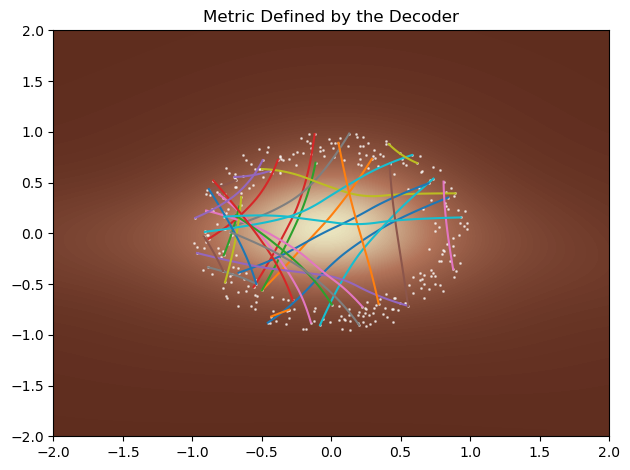

In [26]:
# Plot the magnification factor
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dec, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
c.plot()
plt.title("Metric Defined by the Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [27]:
class DoubleDecoder(nn.Module):
    def __init__(self, z_dim=2, out_dim=100, mean_value=0.0, std_value=1.0, device='cpu'):
        super(DoubleDecoder, self).__init__()
        self.z_dim = z_dim
        self.out_dim = out_dim
        self.mu = get_decoder()
        self.sigma = get_decoder()
        _mean = torch.full((out_dim,), mean_value, device=device)
        _std = torch.full((out_dim,), std_value, device=device)
        covariance_matrix = torch.diag(_std ** 2)  # Diagonal covariance matrix
        self.noise = MultivariateNormal(_mean, covariance_matrix)

    def forward(self, x, randomness=False, return_sigma=False):
        __sigma = self.sigma(x) * self.noise.sample((x.shape[0],)).to(x.device) if randomness else self.sigma(x)
        __y_hat = self.mu(x) + __sigma
        if return_sigma:
            return __y_hat, __sigma
        else:
            return __y_hat

In [28]:
double_model = DoubleDecoder(device=device)
double_model.train();
d_opt = torch.optim.Adam(double_model.parameters(), lr=1e-3)

In [29]:
double_model.to(device)
losses = []
sigmas = []
for epoch in tqdm(range(epochs)):
    for batch in train_loader:
        z, y = batch
        z = z.to(device)
        d_opt.zero_grad()
        y_hat, _sigma = double_model(z, randomness=True, return_sigma=True)
        loss = torch.nn.functional.mse_loss(y_hat, y.to(device))
        losses.append(loss.item())
        sigmas.append(_sigma.detach().mean().item())
        loss.backward()
        d_opt.step()

  0%|          | 0/40 [00:00<?, ?it/s]

In [30]:
# plot the sigmas
#plt.plot(sigmas)

In [31]:
double_model.eval();
with torch.no_grad():
    _, _sigma = double_model(z_grid_list, return_sigma=True)
    _sigma = _sigma.cpu().detach().numpy().mean(axis=1).reshape((grid_size, grid_size))
_sigma.shape

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

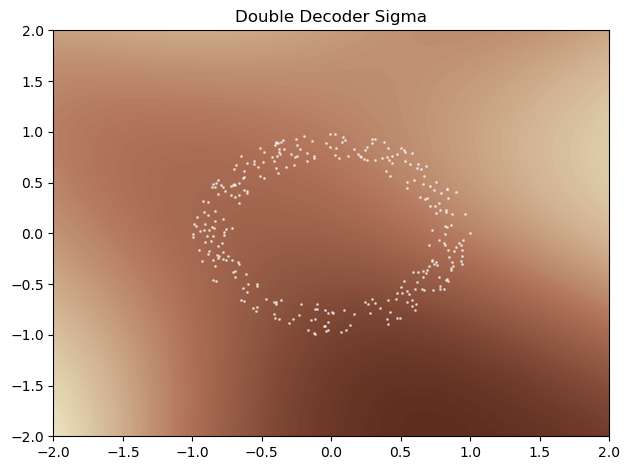

In [148]:
plt.figure()
plt.contourf(x_lin, y_lin, _sigma, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
plt.title("Double Decoder Sigma")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()

In [32]:
class DoubleDecoderInducedManifold(EmbeddedManifold):
    def __init__(self, decoder):
        self.decoder = decoder

    def metric(self, points: torch.Tensor):
        _, J_mean, J_sigma = self.embed(points, jacobian=True)  # NxDx(d)
        M_m = torch.einsum("bji,bjk->bik", J_mean, J_mean)
        M_s = torch.einsum("bji,bjk->bik", J_sigma, J_sigma)
        return M_m + M_s

    def embed(self, c, jacobian=False):
        if jacobian:
            J_mean = vmap(jacfwd(self.decoder.mu))(c)
            J_sigma = vmap(jacfwd(self.decoder.sigma))(c)
            return self.decoder(c), J_mean, J_sigma
        else:
            return self.decoder(c)

In [33]:
double_model.to('cpu')
ddM = DoubleDecoderInducedManifold(double_model)
vol_by_dd = ddM.volume(z_grid_list.cpu()).detach().numpy().reshape((grid_size, grid_size))
dd_c, _ = ddM.connecting_geodesic(p0=data[curve_indices[:, 0]], p1=data[curve_indices[:, 1]])

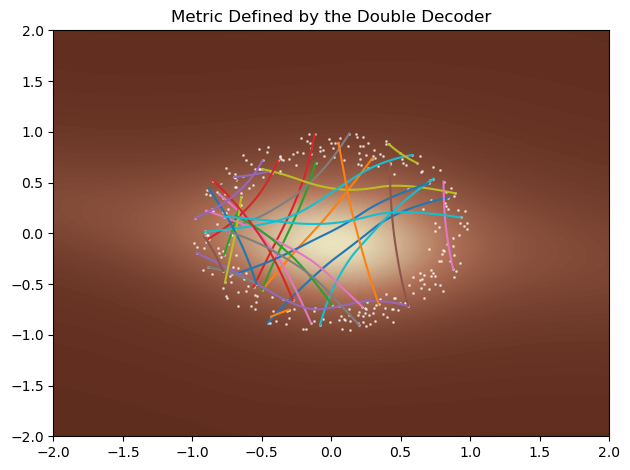

In [34]:
plt.figure()
plt.contourf(x_lin, y_lin, vol_by_dd, levels=100, cmap=rbrown_yellow_cmap)  # Use the custom brownish colormap
plt.scatter(data[:, 0].cpu().numpy(), data[:, 1].cpu().numpy(), s=1, alpha=0.6,c='w')
dd_c.plot()
plt.title("Metric Defined by the Double Decoder")
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.tight_layout()
plt.show()